In [1]:
import sys
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/gcta/scripts')

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from compile_gcta_df import *
import statsmodels.stats.multitest as multi
from adjustText import adjust_text

In [3]:
import scipy
from scipy import stats

In [4]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get GCTA results for TPM, FireBrowse, PanCanAtlas

In [6]:
def fdr(df,pseudo):
    #make heritability estimate numeric
    df["V(G)/Vp"]=pd.to_numeric(df["V(G)/Vp"])
    #add pseudocount
    if pseudo == True:
        df["Pval"]=df["Pval"]+0.0000001
    
    #calculate benjamin-hochberg fdr
    genes=df["gene"].tolist()
    probabilities = df["Pval"].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)


In [7]:
pseudocount=True

In [8]:
results=[""]
cis=compile_gcta_results(results,output="overall",direct="/cellar/users/mpagadal/Data/gcta/results/tcga/brian-tpm/cis2/")
sig=compile_gcta_results(results,output="overall",direct="/cellar/users/mpagadal/Data/gcta/results/tcga/brian-tpm/sig2/")

compiling gene level heritability dataframe.....


/cellar/users/mpagadal/Data/gcta/scripts/compile_gcta_df.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variance["V(G) SE"]=se[0].tolist()
/cellar/users/mpagadal/Data/gcta/scripts/compile_gcta_df.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variance["V(e) SE"]=se[1].tolist()
/cellar/users/mpagadal/Data/gcta/scripts/compile_gcta_df.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

compiling gene level heritability dataframe.....


In [9]:
cis=cis.rename(columns={"V(G)/Vp":"cis V(G)/Vp"})
sig=sig.rename(columns={"V(G)/Vp":"sig V(G)/Vp"})

In [10]:
df_plot=pd.merge(cis[["gene","cis V(G)/Vp"]],sig[["gene","sig V(G)/Vp"]])

In [11]:
df_plot.head()

,gene,cis V(G)/Vp,sig V(G)/Vp
0,CAPZA2,1e-06,0.018654
1,SKIL,1e-06,0.006544
2,CD86,0.00167,0.035573
3,TAP2,1e-06,0.012591
4,LILRB4,0.182968,0.203615


In [12]:
df_plot["cis V(G)/Vp"]=pd.to_numeric(df_plot["cis V(G)/Vp"])
df_plot["sig V(G)/Vp"]=pd.to_numeric(df_plot["sig V(G)/Vp"])

In [13]:
df_plot_sum=pd.merge(df_plot.mean().reset_index(),df_plot.std().reset_index(),left_index=True, right_index=True)

In [14]:
df_plot_sum["se"]=df_plot_sum["0_y"]/np.sqrt(134)

In [15]:
df_plot_sum

,index_x,0_x,index_y,0_y,se
0,cis V(G)/Vp,0.016269,cis V(G)/Vp,0.046308,0.004000
1,sig V(G)/Vp,0.040598,sig V(G)/Vp,0.067986,0.005873


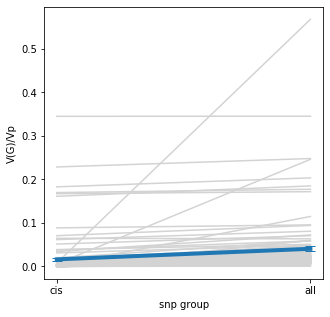

In [16]:
f=plt.figure(figsize=(5,5))
for i,row in df_plot.iterrows():
    plt.plot(["cis","all"], [row["cis V(G)/Vp"],row["sig V(G)/Vp"]],color="lightgray")
plt.errorbar(["cis","all"],df_plot_sum["0_x"],yerr=df_plot_sum["se"],linewidth=4,elinewidth=4,capsize=5)
plt.ylabel("V(G)/Vp")
plt.xlabel("snp group")
plt.savefig("variance.explained.pdf")

In [18]:
df_plot.sort_values(by="sig V(G)/Vp")

,gene,cis V(G)/Vp,sig V(G)/Vp
39,IL12A,0.000001,0.000001
23,ENO1,0.000001,0.000939
53,PSMC1,0.000001,0.002239
30,UAP1,0.000001,0.003366
132,APITD1,0.004016,0.005722
...,...,...,...
4,LILRB4,0.182968,0.203615
129,HLA.DRB5,0.005858,0.246238
48,LAIR1,0.228718,0.248075
108,ERAP2,0.345087,0.345357


In [21]:
df_plot["diff"]=df_plot["sig V(G)/Vp"]-df_plot["cis V(G)/Vp"]

In [23]:
df_plot

,gene,cis V(G)/Vp,sig V(G)/Vp,diff
0,CAPZA2,0.000001,0.018654,0.018653
1,SKIL,0.000001,0.006544,0.006543
2,CD86,0.001670,0.035573,0.033903
3,TAP2,0.000001,0.012591,0.012590
4,LILRB4,0.182968,0.203615,0.020647
...,...,...,...,...
129,HLA.DRB5,0.005858,0.246238,0.240380
130,CTSW,0.061723,0.080945,0.019222
131,MICB,0.005936,0.026681,0.020745
132,APITD1,0.004016,0.005722,0.001706


In [13]:
sig

,V(G),V(e),Vp,V(G)/Vp,logL,logL0,LRT,df,Pval,n,gene,category,V(G) SE,V(e) SE,V(p) SE,V(G)/Vp SE
Variance,0.211433,0.756725,0.968159,0.218387,-3095.8,-3542.66,893.735,1,0,7113,CD86,,0.014637,0.013624,0.018687,0.012582
Variance,0.124564,0.866076,0.99064,0.125741,-3392.36,-3547.83,310.94,1,0,7113,RNF41,,0.011478,0.015561,0.017567,0.010669
Variance,0.114225,0.878772,0.992997,0.115031,-3420.81,-3546.97,252.321,1,0,7113,SKIL,,0.011178,0.015802,0.017482,0.010475
Variance,0.106744,0.889489,0.996234,0.107148,-3446.4,-3547.63,202.469,1,0,7113,SEC31A,,0.011062,0.016022,0.017461,0.010412
Variance,0.147483,0.842969,0.990452,0.148905,-3344.77,-3552.3,415.052,1,0,7113,ITGAV,,0.012446,0.015168,0.017914,0.011307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Variance,0.179221,0.793494,0.972715,0.184249,-3199.99,-3541.33,682.676,1,0,7113,VSIG4,,0.013370,0.014263,0.018125,0.011897
Variance,0.076228,0.919424,0.995652,0.076561,-3492.5,-3549.76,114.516,1,0,7113,RBM14,,0.009697,0.016522,0.017100,0.009371
Variance,0.092865,0.875076,0.967941,0.09594,-3362.81,-3463.97,202.324,1,0,7113,MICB,,0.010102,0.015715,0.016810,0.009879
Variance,0.219379,0.734561,0.95394,0.229972,-3011.4,-3393.01,763.222,1,0,7113,HLA.DQA2,,0.015291,0.013286,0.018798,0.013179


In [13]:
pca=fdr(pca,True)

In [21]:
pca=pca.sort_values(by="V(G)/Vp")

In [22]:
pca

,V(G),V(e),Vp,V(G)/Vp,logL,logL0,LRT,df,Pval,n,gene,category,V(G) SE,V(e) SE,V(p) SE,V(G)/Vp SE,fdr,-log10(fdr)
Variance,2.7e-05,27.1258,27.1258,0.000001,-17501.3,-17501.3,0,1,0.5,8135,PC4,,1.058435,1.139892,0.425399,0.039019,0.500000,0.301030
Variance,1e-05,9.59697,9.59698,0.000001,-13276.5,-13276.5,0,1,0.5,8135,PC8,,0.382781,0.411505,0.150505,0.039886,0.500000,0.301030
Variance,0.362975,19.677,20.04,0.018113,-16270.3,-16270.4,0.23,1,0.31571,8135,PC5,,0.793325,0.850309,0.314280,0.039585,0.394638,0.403802
Variance,1.02209,43.1328,44.1549,0.023148,-19482.3,-19482.5,0.419,1,0.25872,8135,PC3,,1.723871,1.848537,0.692469,0.039038,0.369600,0.432268
Variance,2.49063,62.9135,65.4041,0.038081,-21079.5,-21081,2.829,1,0.0462941,8135,PC2,,2.137801,2.345869,1.025743,0.032675,0.103236,0.986168
Variance,5.69313,135.653,141.346,0.040278,-24212.9,-24214.2,2.715,1,0.0496891,8135,PC1,,4.844027,5.269542,2.216771,0.034259,0.103236,0.986168
Variance,0.710563,16.4925,17.2031,0.041304,-15649.3,-15650,1.377,1,0.12034,8135,PC6,,0.694718,0.738155,0.269807,0.040370,0.200567,0.697741
Variance,0.457453,6.97318,7.43063,0.061563,-12235.5,-12236.9,2.655,1,0.0516181,8135,PC10,,0.314668,0.330820,0.116555,0.042317,0.103236,0.986168
Variance,0.581965,8.52802,9.10999,0.063882,-13063.9,-13065.9,3.847,1,0.0249151,8135,PC9,,0.357662,0.379118,0.142895,0.039228,0.103236,0.986168
Variance,1.04916,13.1088,14.1579,0.074104,-14856.3,-14861.6,10.647,1,0.00055126,8135,PC7,,0.510171,0.545447,0.222082,0.035991,0.005513,2.258644


(array([-0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,
         0.12]),
 <a list of 10 Text xticklabel objects>)

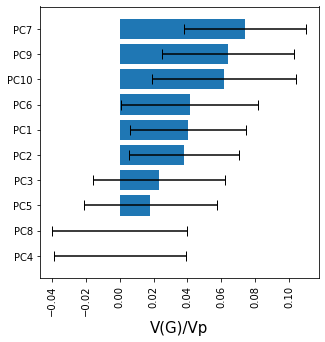

In [24]:
f=plt.figure(figsize=(5,5))
plt.barh(pca["gene"], pca["V(G)/Vp"],xerr=pca["V(G)/Vp SE"],capsize=5)
plt.yticks(fontsize=10)
plt.xlabel("V(G)/Vp",fontsize=15)
plt.xticks(fontsize=10)
#plt.xticks(y_pos, bars)
plt.xticks(rotation=90)

In [9]:
brian=fdr(brian,pseudocount)
firebrowse=fdr(firebrowse,pseudocount)
pancan=fdr(pancan,pseudocount)

In [10]:
#map all ids to standard

mp_ids={"CMC2":"C16orf61",
    "ADGRE5":"CD97",
    "SPRYD7":"C13orf1",
    "JCHAIN":"IGJ",
    "CTSL":"CTSL1",
    "CTSV":"CTSL2",
     "TEX30":"C13orf27",
     "CENPU":"MLF1IP",
     "CMSS1":"C3orf26",
     "FAM216A":"C12orf24",
     "HACD2":"PTPLB", "MARCHF1":"MARCH1"}
mp_ids= {v: k for k, v in mp_ids.items()}

brian["gene"].replace(mp_ids, inplace=True)
firebrowse["gene"].replace(mp_ids, inplace=True)
pancan["gene"].replace(mp_ids, inplace=True)

In [11]:
#rename columns
brian=brian.rename(columns={"V(G)/Vp":"brian V(G)/V(p)","-log10(fdr)":"brian -log10(fdr)"})
firebrowse=firebrowse.rename(columns={"V(G)/Vp":"firebrowse V(G)/V(p)","-log10(fdr)":"firebrowse -log10(fdr)"})
pancan=pancan.rename(columns={"V(G)/Vp":"pancan V(G)/V(p)","-log10(fdr)":"pancan -log10(fdr)"})

In [12]:
#merge columns
total=pd.merge(brian[["brian V(G)/V(p)","gene","brian -log10(fdr)"]],firebrowse[["firebrowse V(G)/V(p)","gene","firebrowse -log10(fdr)"]], on="gene",how="outer")
total=pd.merge(total,pancan[["pancan V(G)/V(p)","gene","pancan -log10(fdr)"]],on="gene",how="outer")

In [13]:
total[total["gene"]=="B2M"]

,brian V(G)/V(p),gene,brian -log10(fdr),firebrowse V(G)/V(p),firebrowse -log10(fdr),pancan V(G)/V(p),pancan -log10(fdr)
646,0.221138,B2M,3.949372,0.071132,0.615906,0.05796,0.516996


In [14]:
#get consensus
total["consensus V(g)/V(p)"]=total[["brian V(G)/V(p)","firebrowse V(G)/V(p)","pancan V(G)/V(p)"]].apply(lambda x: len([x for x in list(x) if x>0.05]), axis=1)
total["consensus fdr"]=total[["brian -log10(fdr)","firebrowse -log10(fdr)","pancan -log10(fdr)"]].apply(lambda x: len([x for x in list(x) if x>1.3]), axis=1)

In [15]:
#keep only genes with phenotype values in at least 2 datasets
total["null"]=total[["brian V(G)/V(p)","firebrowse V(G)/V(p)","pancan V(G)/V(p)"]].apply(lambda x: len([x for x in list(x) if np.isnan(x)]), axis=1)
total=total[total["null"]<2]
df_genes=pd.DataFrame({"genes":total["gene"].tolist()})
df_genes.to_csv("immune.genes.2.rna.txt",index=None,sep="\t")

In [16]:
#make column of size of scatterplot
total["size"]=(total["consensus V(g)/V(p)"]*30)+10

In [17]:
with open('/cellar/users/mpagadal/Data/projects/germline-immune/notebooks/pheno_dictionary.json', 'r') as f:
    pheno_dict = json.load(f)
total["category"]=total["gene"].map(pheno_dict)

In [18]:
#significant heritability genes
# at least 2 rna sources with heritability estimates > 0.05
# at least 1 of the heritability estimates must have FDR > 10%
sig=total[(total["consensus V(g)/V(p)"]>1)&(total["consensus fdr"]>0)]["gene"].tolist()

In [19]:
gcta_sig=pd.DataFrame({"genes":sig})
gcta_sig.to_csv("gcta_significant_genes.txt",header=None,index=None)

In [20]:
"There are {} heritable immune traits".format(len(sig))

'There are 137 heritable immune traits'

In [21]:
"The following immune genes are heritable: {}".format(" ".join(sig))

'The following immune genes are heritable: CD44 SEC24C ITGB2 OAS1 PLOD2 PGM2 DBNDD1 SLC25A40 HCK MARVELD2 CANX AMPD3 TREX1 CSF1R CD163 FCGR3A BTN3A2 CHUK SAMHD1 BSG MS4A4A CLEC4A FPR3 IFI6 ERAP2 PIK3CG CBX1 NEO1 CTSD ISG15 TRAF6 CD84 SLC11A1 ADCY7 FCGR2A PSMD11 HLA.DRB5 IFI44L HAUS1 GPLD1 NCF2 ALOX5AP HLA.F ENTPD1 HLA.A CTSL CD53 STAT1 TLR2 SMAD4 APITD1 CYBB IL1B RBM14 CD14 VSIG4 MARCHF1 CD68 HLA.DQA1 CD209 MICB RAB35 CTSW DYNLT1 MYO1F TAP2 LYN CCBL2 CD86 TNFRSF1A SKIL TRA2B ITGAV RNF41 SEC22B CAPZA2 IGF2R HLA.DQA2 LILRB4 VAMP3 IL1A FPR1 CYBA NUTF2 MICA CAPZB CTSS PSMC1 WDR54 IL2RA PSMB7 IL10RA LAIR1 FCGR2B PSMB9 IL10 PLEK OAS3 ERLIN1 HLA.DRB1 ENO1 HLA.B UAP1 SEC24A DCTN5 IL12A LNPEP COX17 DHFR MNDA FCGR3B C3AR1 SH3BP5L PSMD2 LYZ LILRB2 GNPTAB ERAP1 HLA.DQB1 SLC25A5 CD80 CSF3R B2M HLA.C KIF2A SEC31A SIGLEC5 FAM167A COL8A1 CTNNB1 TAB1 TNFSF13B EIF2AK1 LM22.Macrophages.M2 HLA.G HLA.H HLA.DQB2'

In [22]:
total[total["gene"].isin(sig)]["category"].value_counts()

immunomodulators       70
antigen present        41
immune checkpoint      11
cell type              10
TGFbeta                 3
immune infiltration     1
IFNG                    1
Name: category, dtype: int64

In [23]:
total.head()

,brian V(G)/V(p),gene,brian -log10(fdr),firebrowse V(G)/V(p),firebrowse -log10(fdr),pancan V(G)/V(p),pancan -log10(fdr),consensus V(g)/V(p),consensus fdr,null,size,category
0,0.000001,COL6A3,0.301030,0.000486,0.301030,0.000001,0.301030,0,0,0,10,immunomodulators
1,0.052471,SEC24D,1.113814,0.029511,0.375324,0.047352,0.601686,1,0,0,40,antigen present
2,0.078043,ITGB5,2.092649,0.028979,0.411689,0.015662,0.301030,1,1,0,40,immunomodulators
3,0.127365,CD44,1.844916,0.061509,0.438583,0.069927,0.526651,3,1,0,100,immunomodulators
4,0.024742,DCK,0.475918,0.067392,0.568615,0.078741,0.802715,2,0,0,70,immunomodulators


In [24]:
total["color"]="silver"
total["color"]=np.where((total['consensus V(g)/V(p)']>1), "silver",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="antigen present"),"#66c2a5",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="immunomodulators"),"#fc8d62",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="immune checkpoint"),"#8da0cb",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="cell type"),"#e78ac3",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="TGFbeta"),"#a6d854",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="IFNG"),"#ffd92f",total.color)
total["color"]=np.where((total['consensus V(g)/V(p)']>1)&(total["consensus fdr"]>0)&(total['category']=="immune infiltration"),"#e5c494",total.color)

In [25]:
df_label=total[(total["color"]!="silver")&(total["brian V(G)/V(p)"]>0.10)]

In [26]:
mp_color={"#66c2a5":"antigen present","#fc8d62":"immunomodulators","#8da0cb":"immune checkpoint","#e78ac3":"cell type","#a6d854":"TGFbeta","#ffd92f":"IFNG","#e5c494":"immune infiltration","silver":""}

In [27]:
total["max V(g)/V(p)"]=total[["brian V(G)/V(p)", "firebrowse V(G)/V(p)","pancan V(G)/V(p)"]].max(axis=1)
total["max log10fdr"]=total[["brian -log10(fdr)", "firebrowse -log10(fdr)","pancan -log10(fdr)"]].max(axis=1)

In [28]:
total.head()

,brian V(G)/V(p),gene,brian -log10(fdr),firebrowse V(G)/V(p),firebrowse -log10(fdr),pancan V(G)/V(p),pancan -log10(fdr),consensus V(g)/V(p),consensus fdr,null,size,category,color,max V(g)/V(p),max log10fdr
0,0.000001,COL6A3,0.301030,0.000486,0.301030,0.000001,0.301030,0,0,0,10,immunomodulators,silver,0.000486,0.301030
1,0.052471,SEC24D,1.113814,0.029511,0.375324,0.047352,0.601686,1,0,0,40,antigen present,silver,0.052471,1.113814
2,0.078043,ITGB5,2.092649,0.028979,0.411689,0.015662,0.301030,1,1,0,40,immunomodulators,silver,0.078043,2.092649
3,0.127365,CD44,1.844916,0.061509,0.438583,0.069927,0.526651,3,1,0,100,immunomodulators,#fc8d62,0.127365,1.844916
4,0.024742,DCK,0.475918,0.067392,0.568615,0.078741,0.802715,2,0,0,70,immunomodulators,silver,0.078741,0.802715


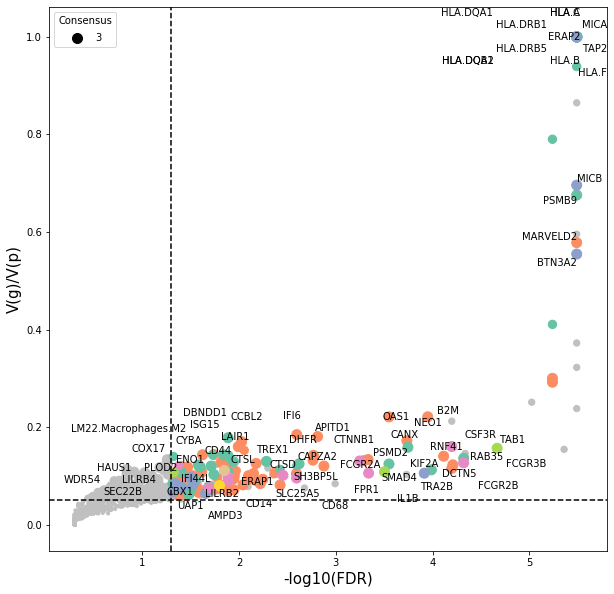

In [29]:
f=plt.figure(figsize=(10,10))
for x in total["color"].unique():
    sc=plt.scatter(total[total["color"]==x]["max log10fdr"],total[total["color"]==x]["max V(g)/V(p)"],
                color=total[total["color"]==x]["color"],s=total[total["color"]==x]["size"],label=mp_color[x])

plt.ylabel("V(g)/V(p)",fontsize=15)
plt.xlabel("-log10(FDR)",fontsize=15)
plt.axvline(x=1.3,color="k",linestyle="--")
plt.axhline(y=0.05,color="k",linestyle="--")

texts=[]
for i,row in df_label.iterrows(): 
    texts.append(plt.text(float(row["brian -log10(fdr)"]),float(row["brian V(G)/V(p)"]),row["gene"],color="black"))
    
adjust_text(texts,only_move={'points':'y', 'texts':'y'}, color='black', lw=0.5)

kw = dict(prop="sizes", num=5, color="k",
          func=lambda s: (s-10)/30)
plt.legend(*sc.legend_elements(**kw),
                    loc="upper left", title="Consensus")

f.savefig("../plots/consensus-heritability-barplot.pdf", bbox_inches='tight')


## Get HLA-nonHLA information

In [30]:
nonhla=pd.read_csv("nonhla_gcta_results.tsv",delimiter="\t")
hla=pd.read_csv("hla_gcta_results.tsv",delimiter="\t")

In [31]:
df_hla=pd.merge(nonhla,hla,on=["gene"],suffixes=("_nonhla","_hla"))

In [32]:
df_hla["brian diff"]=df_hla["brian V(G)/V(p)_nonhla"]-df_hla["brian V(G)/V(p)_hla"]
df_hla["firebrowse diff"]=df_hla["firebrowse V(G)/V(p)_nonhla"]-df_hla["firebrowse V(G)/V(p)_hla"]
df_hla["pancan diff"]=df_hla["pancan V(G)/V(p)_nonhla"]-df_hla["pancan V(G)/V(p)_hla"]

In [33]:
df_hla["consensus nonhla"]=df_hla[["brian diff","firebrowse diff","pancan diff"]].apply(lambda x: len([x for x in list(x) if x>0]), axis=1)

In [34]:
hla_genes=df_hla[(df_hla["gene"].isin(sig))&(df_hla["consensus nonhla"]<=2)]["gene"].tolist()
print(len(hla_genes))
" ".join(hla_genes)

17


'HLA.DRB5 MICB HLA.A HLA.F HLA.DQA1 BTN3A2 HLA.DQB1 HLA.C HLA.DQA2 PSMB9 TAP2 HLA.DRB1 MICA HLA.B HLA.G HLA.H HLA.DQB2'

In [35]:
len([x for x in hla_genes if x in df_hla[~(df_hla["brian V(G)/V(p)_hla"].isnull())]["gene"].tolist()])

14

In [36]:
len([x for x in hla_genes if x in df_hla[~(df_hla["pancan V(G)/V(p)_hla"].isnull())]["gene"].tolist()])

17

In [37]:
nonhla_genes=df_hla[(df_hla["gene"].isin(sig))&(df_hla["consensus nonhla"]>2)]["gene"].tolist()
print(len(nonhla_genes))
" ".join(nonhla_genes)

120


'TLR2 APITD1 ADCY7 CD53 CTSL DYNLT1 GPLD1 CTSW HCK HAUS1 CD14 MARCHF1 CD68 IL1B CYBB PSMD11 SMAD4 FCGR2A STAT1 RBM14 BSG VSIG4 ENTPD1 NCF2 RAB35 CD209 IFI44L CLEC4A ITGB2 FPR3 MS4A4A SIGLEC5 SAMHD1 FAM167A CHUK PLOD2 MARVELD2 FCGR3A CD84 EIF2AK1 SLC25A40 AMPD3 CBX1 NEO1 PIK3CG CTSD CSF1R TREX1 IFI6 DBNDD1 PGM2 CD163 OAS1 SH3BP5L SEC24C CD44 ERAP2 CANX SLC25A5 ISG15 TRAF6 C3AR1 COX17 SEC31A LNPEP PSMD2 LM22.Macrophages.M2 ERAP1 LYN CSF3R CTNNB1 TAB1 COL8A1 GNPTAB LILRB2 KIF2A TNFSF13B FCGR3B DHFR MNDA CD80 PLEK TRA2B B2M CCBL2 IL10 MYO1F FCGR2B RNF41 IL10RA ITGAV SEC24A UAP1 VAMP3 LYZ IGF2R TNFRSF1A WDR54 PSMC1 CAPZB ENO1 OAS3 NUTF2 ERLIN1 LAIR1 SEC22B PSMB7 IL2RA SLC11A1 CD86 SKIL CTSS DCTN5 IL12A LILRB4 FPR1 CYBA IL1A CAPZA2 ALOX5AP'

In [39]:
df_hla["max hla V(g)/V(p)"]=df_hla[["brian V(G)/V(p)_hla", "firebrowse V(G)/V(p)_hla","pancan V(G)/V(p)_hla"]].max(axis=1)
df_hla["max nonhla V(g)/V(p)"]=df_hla[["brian V(G)/V(p)_nonhla", "firebrowse V(G)/V(p)_nonhla","pancan V(G)/V(p)_nonhla"]].max(axis=1)

In [46]:
df_hla["difference"]=df_hla["max hla V(g)/V(p)"]

In [47]:
df_hla=df_hla.sort_values(by="difference")

In [48]:
df_hla=df_hla[df_hla["gene"].isin(sig)]

In [49]:
df_hla_plot=pd.melt(df_hla, id_vars=['gene','difference'], value_vars=['max hla V(g)/V(p)', 'max nonhla V(g)/V(p)'])

In [50]:
df_hla_plot=df_hla_plot.sort_values(by="difference")

In [51]:
df_hla_plot

,gene,difference,variable,value
0,FAM167A,0.000001,max hla V(g)/V(p),0.000001
170,CD163,0.000001,max nonhla V(g)/V(p),0.106940
171,MS4A4A,0.000001,max nonhla V(g)/V(p),0.081905
172,HAUS1,0.000001,max nonhla V(g)/V(p),0.128579
173,EIF2AK1,0.000001,max nonhla V(g)/V(p),0.113756
...,...,...,...,...
134,HLA.DRB5,0.513854,max hla V(g)/V(p),0.513854
272,HLA.B,0.558462,max nonhla V(g)/V(p),0.077809
135,HLA.B,0.558462,max hla V(g)/V(p),0.558462
136,TAP2,0.559842,max hla V(g)/V(p),0.559842


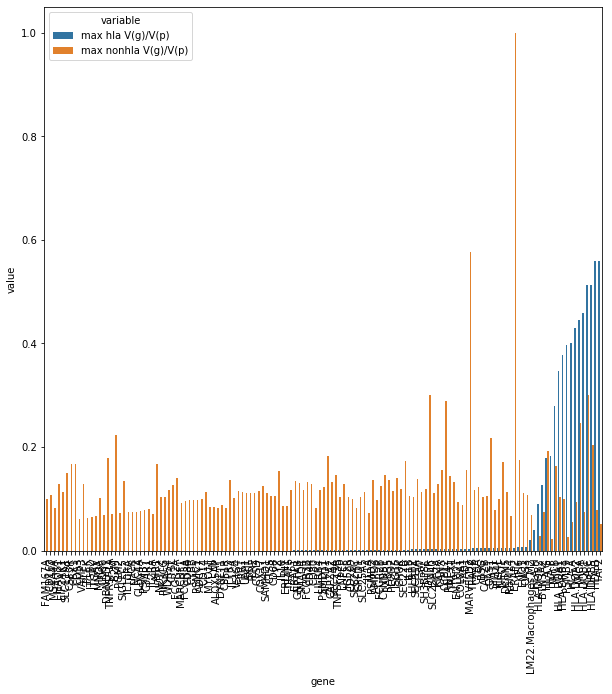

In [52]:
f=plt.figure(figsize=(10,10))
sns.barplot(x="gene", hue="variable", y="value", data=df_hla_plot)
plt.xticks(rotation=90)
f.savefig("../plots/heritability-hla-difference-barplot.pdf", bbox_inches='tight')

In [53]:
for x in sig:
    if x in [y for y in mp_ids.values()]:
        print(x)

CTSL
MARCHF1
